In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from mpl_toolkits.mplot3d import Axes3D   
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.optimize import least_squares



# generating a data set from real data
load your text file with data as file. If using LLR2 or LLR3 data, all data are in 1 file. The first part is for the 2 larger magnets, the second one is for the smallest, LLR1. 

Text(0.5, 1.0, 'B_y vs X')

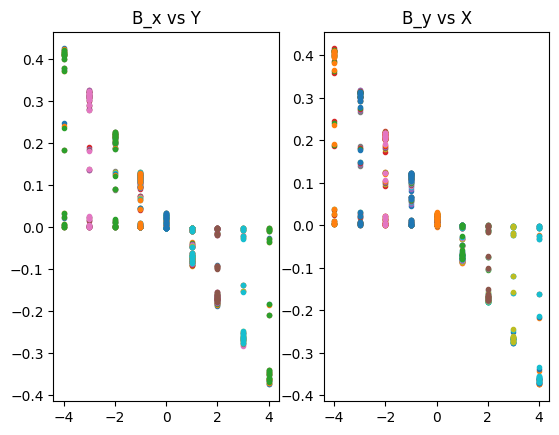

In [301]:


file = 'PMQLLR02_2021_11_15_14.27.txt'
#file = 'QPMLLR3_SNAR_4.5-4.5-5_2023_7_14_18_23.txt'

data = np.genfromtxt(file)

x_local= data[0:,5]
y_local= data[0:,6]
z_local= data[0:,7]
B_x = data[0:,8]
B_y = data[0:,9]
B_z = data[0:,10]

step=len(np.unique(z_local)) #----------> number after which Z values repeated / number of diff Z position
num=len(x_local) #-------------->Total Number of data points for a single parameter

#----------------------- Value at different fixed Z values -------------------

x_local_Z = [x_local[j:num:step]  for j in range(step)]
y_local_Z = [y_local[j:num:step]  for j in range(step)]
z_local_Z = [z_local[j:num:step]  for j in range(step)]
Bx_Z = [B_x[j:num:step]  for j in range(step)]
By_Z = [B_y[j:num:step]  for j in range(step)]
Bz_Z = [B_z[j:num:step]  for j in range(step)]

z_local_val= np.unique(z_local)
#print(z_local_val.shape)


plt.subplot(1,2,1)
plt.plot(y_local_Z,Bx_Z,'.')
plt.title('B_x vs Y')
plt.subplot(1,2,2)
plt.plot(x_local_Z,By_Z,'.')
plt.title('B_y vs X')



In [302]:
def magcentre_4param(X, Bx_00_4simult, By_00_4simult, alpha, G):
    Xc, Yc  = X
    return [Bx_00_4simult + G*np.sin(alpha*(np.pi/180))*Xc + G*np.cos(alpha*(np.pi/180))*Yc ,
           By_00_4simult + G*np.cos(alpha*(np.pi/180))*Xc - G*np.sin(alpha*(np.pi/180))*Yc ]


In [303]:
def simult_fit_4(X, x1, y1, z1, w1): #fitting function
    Bx_00, By_00, G, alpha = X
    return np.array([ z1-(Bx_00 + (G*(np.sin(alpha)))*x1 + (G*(np.cos(alpha)))*y1) ,
                     w1-(By_00 + (G*(np.cos(alpha)))*x1 - (G*(np.sin(alpha)))*y1) ]).flatten()


In [304]:

#defining blank list of variables
Bx_00_6simult,Bx_10_6simult,Bx_01_6simult,By_00_6simult,By_10_6simult,By_01_6simult=[],[],[],[],[],[]
chisq_6param,chisq_4param=[],[]


#----------------------- SIMULTANEOUS FIT OF 4 Parameters {Bx_00, By_00, G, Alpha}----------------------
# This fitting is done by combining both of the files in to single array but for 4 parameter

Bx_00_4simult,By_00_4simult,G,alpha=[],[],[],[]


guess_initial=np.array([0.0,0.0,-0.05,-0.005])

for i in range(0,step):
    x1 = np.array(x_local_Z[i])
    y1 = np.array(y_local_Z[i])
    z1 = np.array(Bx_Z[i])
    w1 = np.array(By_Z[i])
    res_2 = least_squares(simult_fit_4,guess_initial, args=(x1,y1,z1,w1)) #done similar as 6 parameter fitting
    #print(res_2.x)
    Bx_00_4simult.append(res_2.x[0])
    By_00_4simult.append(res_2.x[1])
    G.append(res_2.x[2])
    alpha.append(res_2.x[3]*57.29)
    
    fit_val= simult_fit_4((res_2.x), x1,y1,z1,w1)
    err=1e-4
    chisqr4=np.sum(((fit_val)/err)**2) #done similar as 6 parameter fitting
    chisq_4param.append(chisqr4)
    
    
magcentre_x,magcentre_y=[],[]


#------------> Magnetic Centre from 4 parameters Simultaneous Fitting equations
initial_guess = [1,1]
for i in range(step):   
    centre_4param = fsolve(magcentre_4param ,initial_guess, args=(Bx_00_4simult[i], By_00_4simult[i], alpha[i], G[i]) )
    magcentre_x.append(centre_4param[0]) # Xc for 4 paraameter fit
    magcentre_y.append(centre_4param[1]) # Yc for 4 paraameter fit

In [305]:
def Bx_func(x,y, alpha, G, magCentreX, magCentreY):
    
    return math.sin(alpha*math.pi/180)*G*(x - magCentreX)/10 + math.cos(alpha*math.pi/180)*G*(y - magCentreY)/10

In [306]:
def By_func(x,y, alpha, G, magCentreX, magCentreY):
    
    return math.cos(alpha*math.pi/180)*G*(x - magCentreX)/10 - math.sin(alpha*math.pi/180)*G*(y - magCentreY)/10

In [307]:
def generateB(z_val, alpha, G, magcentreX, magcentreY):

    minLim = -10
    maxLim = 150
    #constants to change depending on magnet
    #LLR3
    #gridRange = 19
    #fringeLength = 11
    #key = "cavity/3Dcavity3"


    #LLR2
    gridRange = 31
    fringeLength = 9
    key = "cavity/3Dcavity2"
    #-----------------------------------------------------------------------

    
    #generate x,y inside bore radius, this is for QPMLLR2, so radius is 9 mm
    xArray = []
    yArray = []
    bx = str(gridRange) + " "
    
    
    for i in range(gridRange):
        xArray.append(-(gridRange-1)/2 + i)
        bx += str((-(gridRange -1)/2 + i)*1e-3) + " "

    bx += "\n" + str(gridRange) + " "
    for i in range(gridRange):
        yArray.append(-(gridRange-1)/2 + i)
        bx += str((-(gridRange-1)/2 + i)*1e-3) + " "

    z_range = []
    for i in range(len(z_val)):
        if z_val[i] < minLim or z_val[i] > maxLim:
            continue
        z_range.append(i)
    
    bx += "\n" + str(z_range[-1] - z_range[0] + 1) + " "   
    for i in z_range:
        bx += str((z_val[i]-fringeLength)*1e-3) + " "
    
    bx += "\n"

    
    by = bx
    bz = bx
    ex = bx
    ey = bx
    ez = bx
    gradient = ""
    limit = z_range[-1]
    print(z_range)
    for i in z_range:
        gradient += str((z_val[i]-fringeLength)*1e-3) + " " + str(G[i]) + "\n"
        for y in yArray:
            for x in xArray:
                Bx = math.ceil(1000000*Bx_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i]))/1000000
                By = math.ceil(1000000*By_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i]))/1000000
                derBx = 0
                if i == 0:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i])/(z_val[i+1] - z_val[i]))
                elif i == limit:
                    derBx = (Bx_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i] - z_val[i-1]))
                else:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i+1] - z_val[i-1]))
                Bz = (derBx*x*y)/( (x-magcentre_x[i])*math.sin(alpha[i]*math.pi/180) + (y-magcentre_y[i])*math.cos(alpha[i]*math.pi/180))
                Bz = math.ceil(Bz*10000000)/10000000


                bx += str(Bx) + " "
                by += str(By) + " "
                bz += str(Bz) + " "
                ex += "0 "
                ey += "0 "
                ez += "0 "

            bx += "\n"
            by += "\n"
            bz += "\n"
            ex += "\n"
            ey += "\n"
            ez += "\n"

    with open(key + "gradient.dat" , "w") as file:
        file.writelines(gradient)
    
    with open(key + ".ex", "w") as file:
        file.writelines(ex)
    with open(key + ".ey", "w") as file:
        file.writelines(ey)
    with open(key + ".ez", "w") as file:
        file.writelines(ez)
        
    with open(key + ".bx", "w") as file:
        file.writelines(bx)
    with open(key + ".by", "w") as file:
        file.writelines(by)
    with open(key + ".bz", "w") as file:
        file.writelines(bz)


    #this part is only for double checking if the fields are similar

    xArray_other, yArray_other = [], []
    for i in range(5):
        xArray_other.append(-9 + 4.5*i)
        yArray_other.append(-9 + 4.5*i)
    
    results = ""
    for y in yArray:
        for x in xArray:
            for i in z_range:

                Bx = math.ceil(1000000*Bx_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i]))/1000000
                By = math.ceil(1000000*By_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i]))/1000000
                derBx = 0
                if i == 0:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i])/(z_val[i+1] - z_val[i]))
                elif i == limit:
                    derBx = (Bx_func(x,y, alpha[i], G[i], magcentre_x[i], magcentre_y[i]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i] - z_val[i-1]))
                else:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentre_x[i+1], magcentre_y[i+1]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentre_x[i-1], magcentre_y[i-1])/(z_val[i+1] - z_val[i-1]))
                Bz = (derBx*x*y)/( (x-magcentre_x[i])*math.sin(alpha[i]*math.pi/180) + (y-magcentre_y[i])*math.cos(alpha[i]*math.pi/180))
                Bz = math.ceil(Bz*10000000)/10000000

                results += "0 0 0 0 0 " + str(x) + " " + str(y) + " " + str(z_val[i]-fringeLength) + " " + str(Bx) + " " + str(By) + " " + str(Bz) + "\n"


    with open("PQMLLR2_generated.txt","w") as file:
        file.writelines(results)
    

    return

In [308]:
generatedData = generateB(z_local_val, alpha, G, magcentre_x, magcentre_y)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [309]:
def runOnceMore(fileName):
    #file = 'PQMLLR3_generated.txt'

    data = np.genfromtxt(fileName)
    
    x_local= data[0:,5]
    y_local= data[0:,6]
    z_local= data[0:,7]
    B_x = data[0:,8]
    B_y = data[0:,9]
    B_z = data[0:,10]
    
    step=len(np.unique(z_local)) #----------> number after which Z values repeated / number of diff Z position
    num=len(x_local) #-------------->Total Number of data points for a single parameter
    
    #----------------------- Value at different fixed Z values -------------------
    
    x_local_Z = [x_local[j:num:step]  for j in range(step)]
    y_local_Z = [y_local[j:num:step]  for j in range(step)]
    z_local_Z = [z_local[j:num:step]  for j in range(step)]
    Bx_Z = [B_x[j:num:step]  for j in range(step)]
    By_Z = [B_y[j:num:step]  for j in range(step)]
    Bz_Z = [B_z[j:num:step]  for j in range(step)]
    
    z_local_val= np.unique(z_local)
    #print(z_local_val.shape)
    
    
    plt.subplot(1,2,1)
    plt.plot(y_local_Z,Bx_Z,'.')
    plt.title('B_x vs Y')
    plt.subplot(1,2,2)
    plt.plot(x_local_Z,By_Z,'.')
    plt.title('B_y vs X')
    

    
    #defining blank list of variables
    chisq_4param=[]
    
    
    #----------------------- SIMULTANEOUS FIT OF 4 Parameters {Bx_00, By_00, G, Alpha}----------------------
    # This fitting is done by combining both of the files in to single array but for 4 parameter
    
    Bx_00_4simult,By_00_4simult,G,alpha=[],[],[],[]
    
    
    guess_initial=np.array([0.015,0.015,-0.01,-0.005])
    
    for i in range(0,step):
        x1 = np.array(x_local_Z[i])
        y1 = np.array(y_local_Z[i])
        z1 = np.array(Bx_Z[i])
        w1 = np.array(By_Z[i])
        res_2 = least_squares(simult_fit_4,guess_initial, args=(x1,y1,z1, w1)) #done similar as 6 parameter fitting
        Bx_00_4simult.append(res_2.x[0])
        By_00_4simult.append(res_2.x[1])
        G.append(res_2.x[2])
        alpha.append(res_2.x[3]*57.29)
        
        fit_val= simult_fit_4((res_2.x),x1,y1,z1,w1)
        err=1e-4
        chisqr4=np.sum(((fit_val)/err)**2) #done similar as 6 parameter fitting
        chisq_4param.append(chisqr4)
        
        
    magcentre_x,magcentre_y=[],[]
    
    
    #------------> Magnetic Centre from 4 parameters Simultaneous Fitting equations
    
    for i in range(step):   
        centre_4param = fsolve(magcentre_4param,[1,1], args=(Bx_00_4simult[i], By_00_4simult[i], alpha[i], G[i]))
        magcentre_x.append(centre_4param[0]) # Xc for 4 paraameter fit
        magcentre_y.append(centre_4param[1]) # Yc for 4 paraameter fit
    

    
    plt.figure(figsize=(20,22))
    row = 5; col =1
    plt.subplots_adjust(hspace =.4)
    #plt.suptitle("{}__Common Fit".format(datafile), fontsize = 15)
    
    plt.subplot(row,col,1)
    plt.plot(z_local_val,chisq_4param,'-',label='4param')
    #plt.ylim(-.1,1e6)
    plt.title('Chisquare (\u03C7 \u00b2) for Parameter Fits ')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(row,col,2)
    plt.plot(z_local_val,Bx_00_4simult,'-',label='Bx_4param')
    plt.plot(z_local_val,By_00_4simult,'-',label='By_4param')
    #plt.ylim(-0.05,+0.05)
    plt.title('Field at origin [T] (fit parameter B\u2080\u2080)')
    plt.legend(loc='best')
    plt.grid()
    
    
    plt.subplot(row,col,3)
    plt.plot(z_local_val,alpha,'-',label='\u03B1_4param')
    plt.ylim(-1,2)
    plt.title('Skew Angle [degree] (\u03B1) {rotation of field} ')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(row,col,4)
    plt.plot(z_local_val,G,'-',label='G_4param')
    #plt.ylim(-0.025,0.01)
    plt.title('Gradient of the field [T/mm] ')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(row,col,5)
    
    plt.plot(z_local_val,magcentre_x,'-',label='Xc_4param')
    plt.plot(z_local_val,magcentre_y,'-',label='Yc_4param')
    plt.ylim(-1,1)
    plt.legend(loc='best')
    plt.grid()    



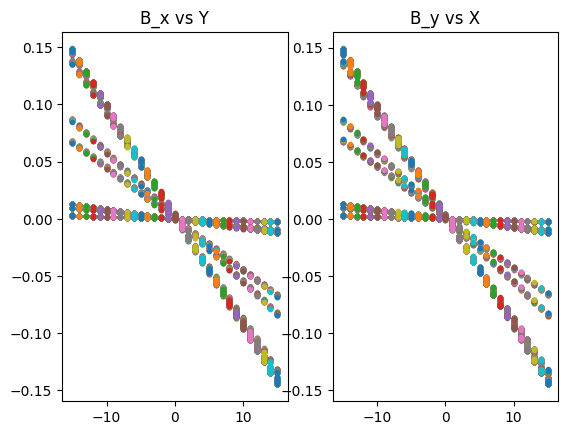

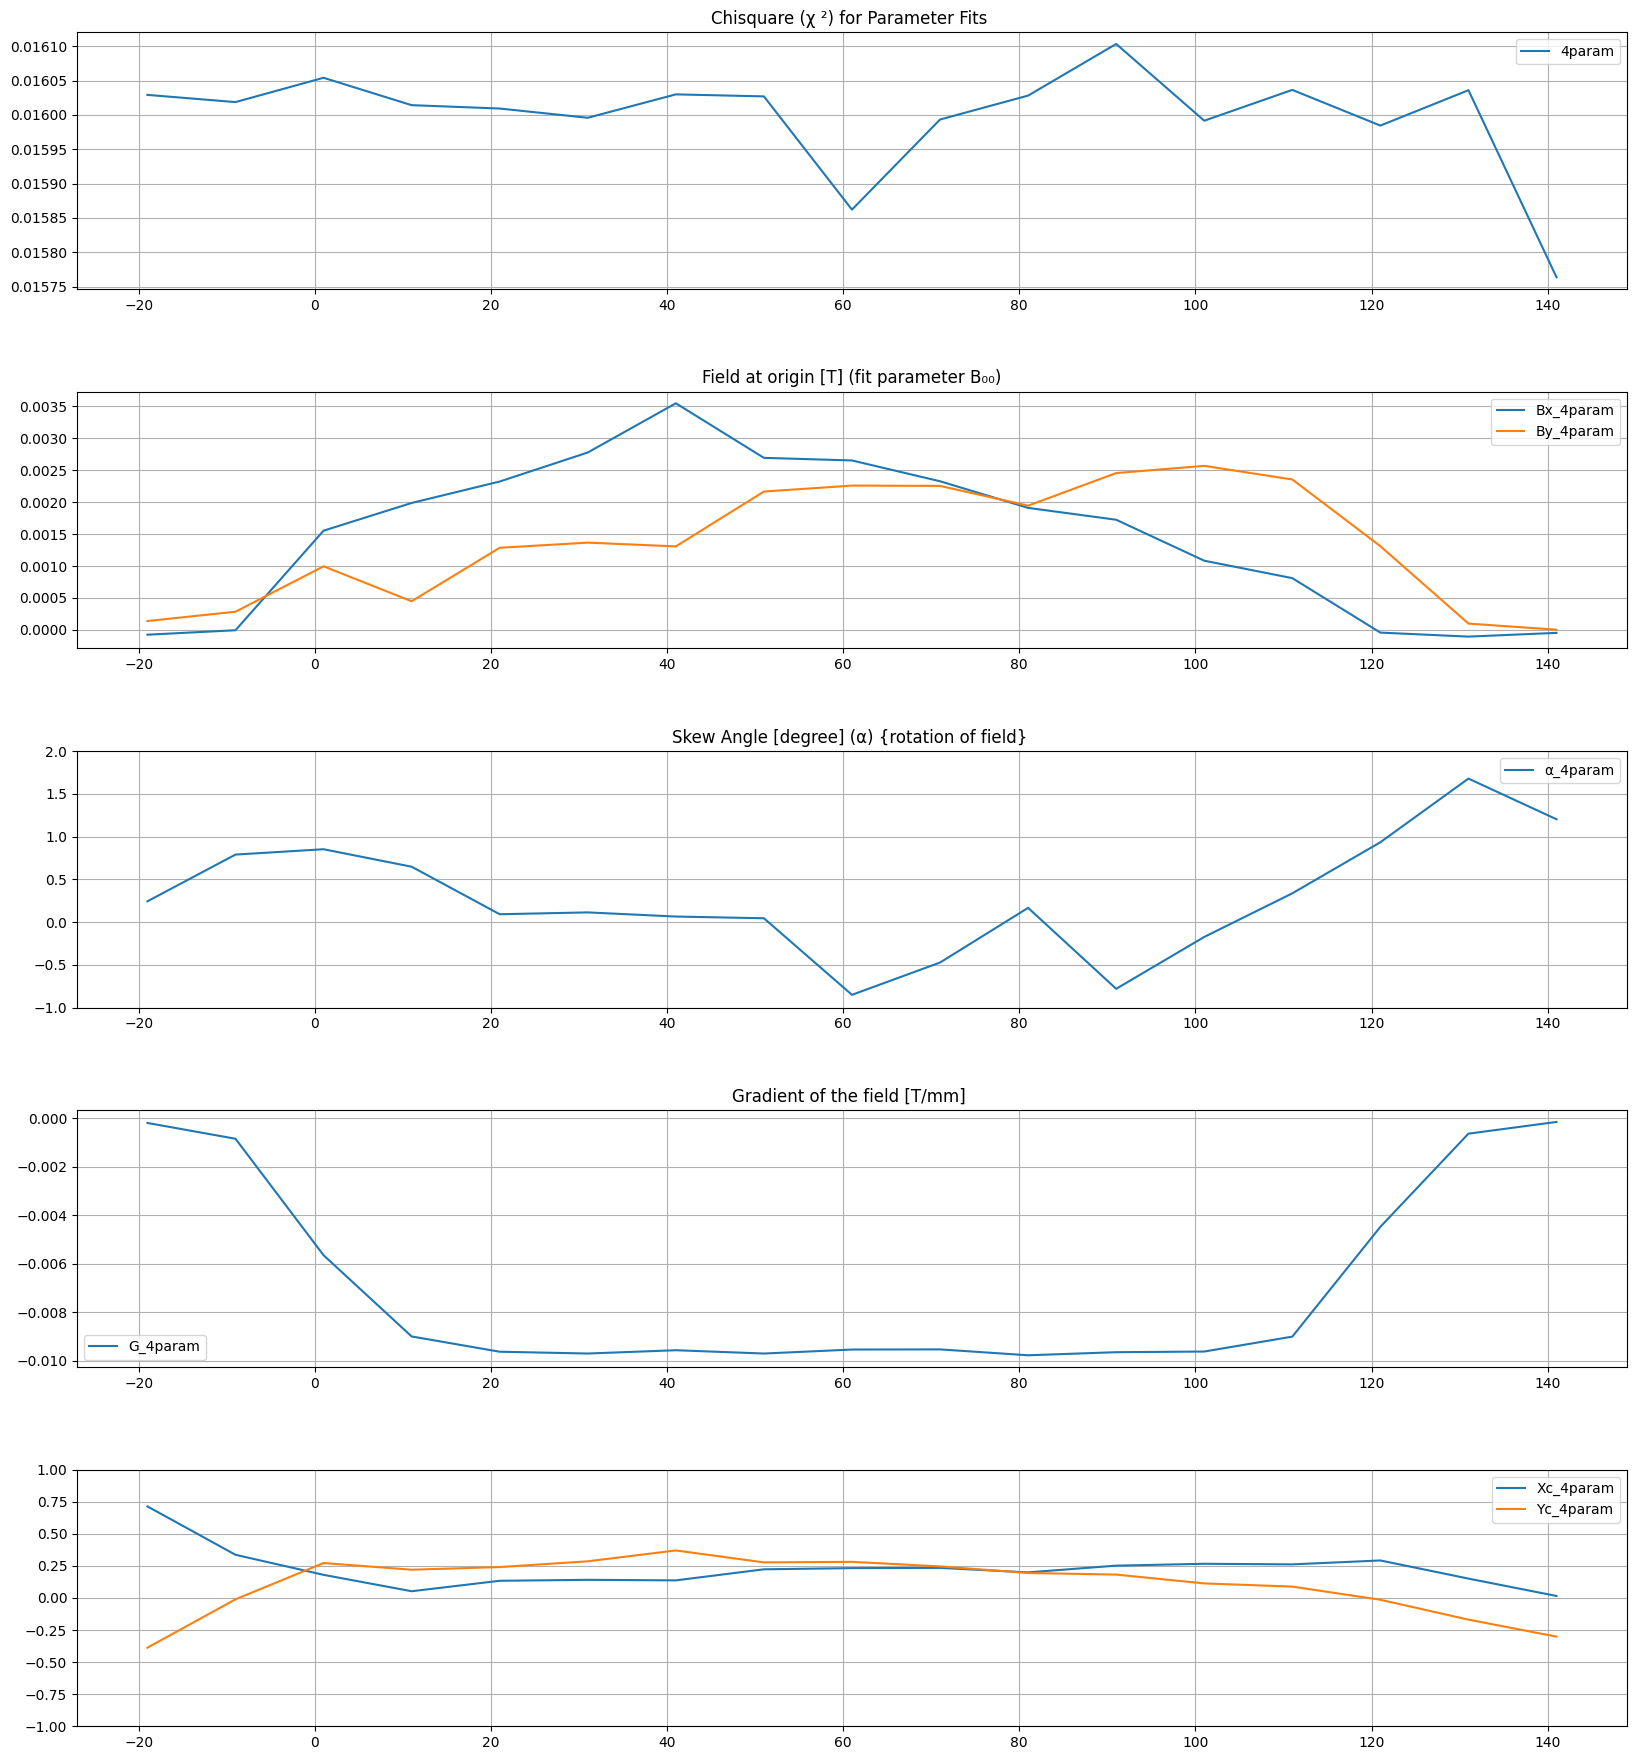

In [310]:
runOnceMore("PQMLLR2_generated.txt")

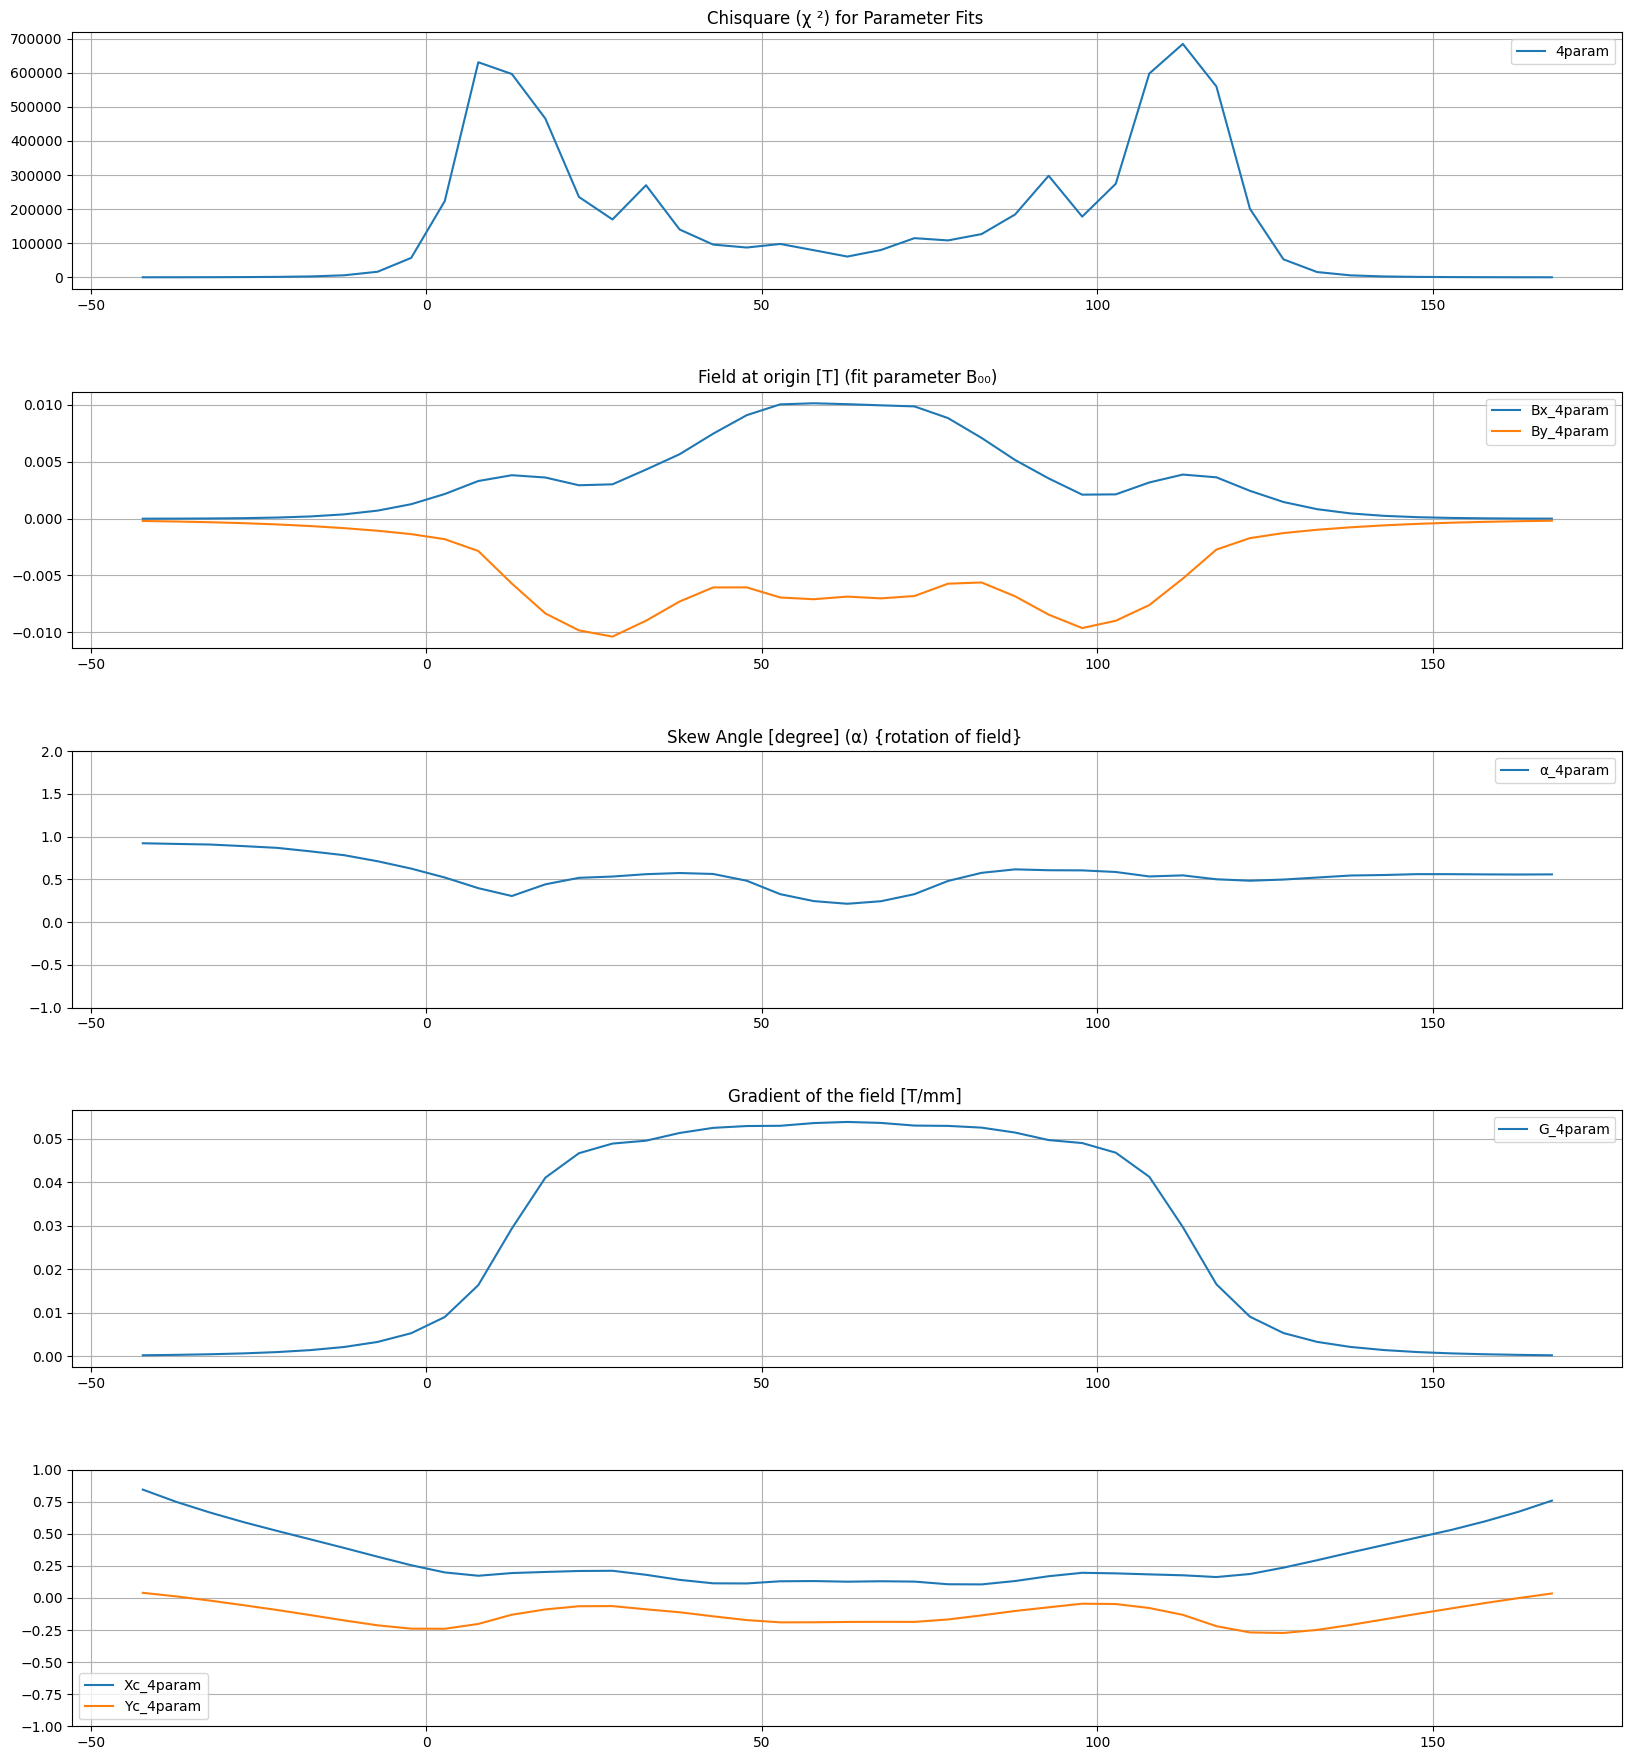

In [300]:

plt.figure(figsize=(20,22))
row = 5; col =1
plt.subplots_adjust(hspace =.4)
#plt.suptitle("{}__Common Fit".format(datafile), fontsize = 15)

plt.subplot(row,col,1)
plt.plot(z_local_val,chisq_4param,'-',label='4param')
#plt.ylim(-.1,1e6)
plt.title('Chisquare (\u03C7 \u00b2) for Parameter Fits ')
plt.legend(loc='best')
plt.grid()

plt.subplot(row,col,2)
plt.plot(z_local_val,Bx_00_4simult,'-',label='Bx_4param')
plt.plot(z_local_val,By_00_4simult,'-',label='By_4param')
#plt.ylim(-0.05,+0.05)
plt.title('Field at origin [T] (fit parameter B\u2080\u2080)')
plt.legend(loc='best')
plt.grid()


plt.subplot(row,col,3)
plt.plot(z_local_val,alpha,'-',label='\u03B1_4param')
plt.ylim(-1,2)
plt.title('Skew Angle [degree] (\u03B1) {rotation of field} ')
plt.legend(loc='best')
plt.grid()

plt.subplot(row,col,4)
plt.plot(z_local_val,G,'-',label='G_4param')
#plt.ylim(-0.025,0.01)
plt.title('Gradient of the field [T/mm] ')
plt.legend(loc='best')
plt.grid()

plt.subplot(row,col,5)

plt.plot(z_local_val,magcentre_x,'-',label='Xc_4param')
plt.plot(z_local_val,magcentre_y,'-',label='Yc_4param')
plt.ylim(-1,1)
plt.legend(loc='best')
plt.grid()


# Generation of a field map for LLR01 magnet
this one is special, becausee the measurement was always done only in 1 dimension, have to load data differently. Also fits were done only separately for gradient and alpha


In [323]:
def generateBLLR1(z_val, alpha, G, magcentreX, magcentreY):

    #constants to change depending on magnet
    #LLR1
    gridRange=15
    fringeLength=0
    key='cavity/3Dcavity1'
    
    #-----------------------------------------------------------------------

    
    #generate x,y inside bore radius, this is for QPMLLR2, so radius is 9 mm
    xArray = []
    yArray = []
    bx = str(gridRange) + " "
    
    
    for i in range(gridRange):
        xArray.append(-(gridRange-1)/4 + i/2)
        bx += str((-(gridRange -1)/4+i/2)*1e-3) + " "

    bx += "\n" + str(gridRange) + " "
    for i in range(gridRange):
        yArray.append(-(gridRange-1)/4 + i/2)
        bx += str((-(gridRange-1)/4+i/2)*1e-3) + " "

    
    z_range = []
    for i in range(len(z_val)):
        if z_val[i] < -10 or z_val[i] > 45:
            continue
        z_range.append(i)
    
    bx += "\n" + str(z_range[-1] - z_range[0] + 1) + " "   
    for i in z_range:
        bx += str((z_val[i])*1e-3) + " "
    
    bx += "\n"

    
    by = bx
    bz = bx
    ex = bx
    ey = bx
    ez = bx
    gradient = ""
    limit = z_range[-1] 
    print(z_range)
    for i in z_range:
        gradient += str((z_val[i])*1e-3) + " " + str(G[i]) + "\n"
        for y in yArray:
            for x in xArray:
                Bx = math.ceil(1000000*Bx_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i]))/1000000
                By = math.ceil(1000000*By_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i]))/1000000
                derBx = 0
                if i == 0:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentreX[i+1], magcentreY[i+1]) -Bx_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i])/(z_val[i+1] - z_val[i]))
                elif i == limit:
                    derBx = (Bx_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentreX[i-1], magcentreY[i-1])/(z_val[i] - z_val[i-1]))
                else:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentreX[i+1], magcentreY[i+1]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentreX[i-1], magcentreY[i-1])/(z_val[i+1] - z_val[i-1]))
                Bz = (derBx*x*y)/( (x-magcentreX[i])*math.sin(alpha[i]*math.pi/180) + (y-magcentreY[i])*math.cos(alpha[i]*math.pi/180))
                Bz = math.ceil(Bz*10000000)/10000000


                bx += str(Bx) + " "
                by += str(By) + " "
                bz += str(Bz) + " "
                ex += "0 "
                ey += "0 "
                ez += "0 "

            bx += "\n"
            by += "\n"
            bz += "\n"
            ex += "\n"
            ey += "\n"
            ez += "\n"
            
    with open(key + "gradient.dat", "w") as file:
        file.write(gradient)
    
    with open(key + ".ex", "w") as file:
        file.writelines(ex)
    with open(key + ".ey", "w") as file:
        file.writelines(ey)
    with open(key + ".ez", "w") as file:
        file.writelines(ez)
        
    with open(key + ".bx", "w") as file:
        file.writelines(bx)
    with open(key + ".by", "w") as file:
        file.writelines(by)
    with open(key + ".bz", "w") as file:
        file.writelines(bz)


    #this part is only for double checking if the fields are similar

    xArray_other, yArray_other = [], []
    for i in range(5):
        xArray_other.append(-9 + 4.5*i)
        yArray_other.append(-9 + 4.5*i)
    
    results = ""
    for y in yArray:
        for x in xArray:
            for i in z_range:

                Bx = math.ceil(1000000*Bx_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i]))/1000000
                By = math.ceil(1000000*By_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i]))/1000000
                derBx = 0
                if i == 0:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentreX[i+1], magcentreY[i+1]) -Bx_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i])/(z_val[i+1] - z_val[i]))
                elif i == limit:
                    derBx = (Bx_func(x,y, alpha[i], G[i], magcentreX[i], magcentreY[i]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentreX[i-1], magcentreY[i-1])/(z_val[i] - z_val[i-1]))
                else:
                    derBx = (Bx_func(x,y, alpha[i+1], G[i+1], magcentreX[i+1], magcentreY[i+1]) -Bx_func(x,y, alpha[i-1], G[i-1], magcentreX[i-1], magcentreY[i-1])/(z_val[i+1] - z_val[i-1]))
                Bz = (derBx*x*y)/( (x-magcentreX[i])*math.sin(alpha[i]*math.pi/180) + (y-magcentreY[i])*math.cos(alpha[i]*math.pi/180))
                Bz = math.ceil(Bz*10000000)/10000000

                results += "0 0 0 0 0 " + str(x) + " " + str(y) + " " + str(z_val[i]) + " " + str(Bx) + " " + str(By) + " " + str(Bz) + "\n"


    with open("PQMLLR1_generated.txt","w") as file:
        file.writelines(results)
    

    return

38
38
[-43. -40. -37. -34. -31. -28. -25. -22. -19. -16. -13. -10.  -7.  -4.
  -1.   2.   5.   8.  11.  14.  17.  20.  23.  26.  29.  32.  35.  38.
  41.  44.  47.  50.  53.  56.  59.  62.  65.  68.]
[-33. -30. -27. -24. -21. -18. -15. -12.  -9.  -6.  -3.   0.   3.   6.
   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.  42.  45.  48.
  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.]


'\nBx_00_4simult,By_00_4simult,G,alpha=[],[],[],[]\n\n\nguess_initial=np.array([0.015,0.015,-0.01,-0.005])\n\nfor i in range(0,step):\n    x1 = np.array(x_local_Z[i])\n    y1 = np.array(y_local_Z[i])\n    z1 = np.array(Bx_Z[i])\n    w1 = np.array(By_Z[i])\n    res_2 = least_squares(simult_fit_4,guess_initial, args=(x1,y1,z1, w1)) #done similar as 6 parameter fitting\n    Bx_00_4simult.append(res_2.x[0])\n    By_00_4simult.append(res_2.x[1])\n    G.append(res_2.x[2])\n    alpha.append(res_2.x[3]*57.29)\n    \n    fit_val= simult_fit_4((res_2.x),x1,y1,z1,w1)\n    err=1e-4\n    chisqr4=np.sum(((fit_val)/err)**2) #done similar as 6 parameter fitting\n    chisq_4param.append(chisqr4)\n    \n    \nmagcentre_x,magcentre_y=[],[]\n\n\n#------------> Magnetic Centre from 4 parameters Simultaneous Fitting equations\n\nfor i in range(step):   \n    centre_4param = fsolve(magcentre_4param,[1,1], args=(Bx_00_4simult[i], By_00_4simult[i], alpha[i], G[i]))\n    magcentre_x.append(centre_4param[0]) # X

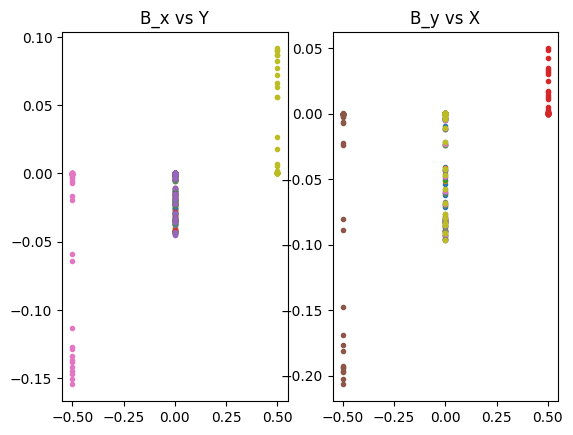

In [324]:

fileX = 'QPMLLR01X.txt'
fileY = 'QPMLLR01Y.txt'

dataX = np.genfromtxt(fileX)
dataY = np.genfromtxt(fileY)


x_local1= dataX[0:,5]
y_local1= dataX[0:,6]
z_local1= dataX[0:,7]

x_local2= dataY[0:,5]
y_local2= dataY[0:,6]
z_local2= dataY[0:,7]


for i in range(len(z_local1)):
    z_local1[i] += -10

B_x = dataX[0:,10]
B_y = dataY[0:,10]

for i in range(len(B_y)):
    B_y[i] = - B_y[i]


step1=len(np.unique(z_local1)) #----------> number after which Z values repeated / number of diff Z position
num1=len(x_local1) #-------------->Total Number of data points for a single parameter


step2=len(np.unique(z_local2)) #----------> number after which Z values repeated / number of diff Z position
num2=len(x_local2) #-------------->Total Number of data points for a single parameter
print(step1)
print(step2)
#----------------------- Value at different fixed Z values -------------------

x_local1_Z = [x_local1[j:num1:step1]  for j in range(step1)]
y_local1_Z = [y_local1[j:num1:step1]  for j in range(step1)]
z_local1_Z = [z_local1[j:num1:step1]  for j in range(step1)]
Bx_Z = [B_x[j:num1:step1]  for j in range(step1)]

x_local2_Z = [x_local2[j:num2:step2]  for j in range(step2)]
y_local2_Z = [y_local2[j:num2:step2]  for j in range(step2)]
z_local2_Z = [z_local2[j:num2:step2]  for j in range(step2)]
By_Z = [B_y[j:num2:step2]  for j in range(step2)]


z_local1_val= np.unique(z_local1)
z_local2_val= np.unique(z_local2)

print(z_local1_val)
print(z_local2_val)

plt.subplot(1,2,1)
plt.plot(x_local1_Z,Bx_Z,'.')
plt.title('B_x vs Y')
plt.subplot(1,2,2)
plt.plot(x_local2_Z,By_Z,'.')
plt.title('B_y vs X')



#defining blank list of variables
chisq_4param=[]


#----------------------- SIMULTANEOUS FIT OF 4 Parameters {Bx_00, By_00, G, Alpha}----------------------
# This fitting is done by combining both of the files in to single array but for 4 parameter

'''
Bx_00_4simult,By_00_4simult,G,alpha=[],[],[],[]


guess_initial=np.array([0.015,0.015,-0.01,-0.005])

for i in range(0,step):
    x1 = np.array(x_local_Z[i])
    y1 = np.array(y_local_Z[i])
    z1 = np.array(Bx_Z[i])
    w1 = np.array(By_Z[i])
    res_2 = least_squares(simult_fit_4,guess_initial, args=(x1,y1,z1, w1)) #done similar as 6 parameter fitting
    Bx_00_4simult.append(res_2.x[0])
    By_00_4simult.append(res_2.x[1])
    G.append(res_2.x[2])
    alpha.append(res_2.x[3]*57.29)
    
    fit_val= simult_fit_4((res_2.x),x1,y1,z1,w1)
    err=1e-4
    chisqr4=np.sum(((fit_val)/err)**2) #done similar as 6 parameter fitting
    chisq_4param.append(chisqr4)
    
    
magcentre_x,magcentre_y=[],[]


#------------> Magnetic Centre from 4 parameters Simultaneous Fitting equations

for i in range(step):   
    centre_4param = fsolve(magcentre_4param,[1,1], args=(Bx_00_4simult[i], By_00_4simult[i], alpha[i], G[i]))
    magcentre_x.append(centre_4param[0]) # Xc for 4 paraameter fit
    magcentre_y.append(centre_4param[1]) # Yc for 4 paraameter fit

'''


In [325]:

def fit_func(X, B_00, B_10, B_01): # Fit Function 
    x,y = X
    return B_00 + B_10*x + B_01*y

param_X, Bx_00, Bx_10,Bx_01, chisq_x=[],[],[],[],[] #blank list for storing values into it

for i in range(0,step1):
    x = np.array(x_local1_Z[i])
    y = np.array(y_local1_Z[i])
    z = np.array(Bx_Z[i])

    param,pocv= (curve_fit(fit_func, (x,y), z)) # fitting done using CurveFit command
    param_X.append(param) # all parameters for each single Z-plane
    Bx_00.append(param[0]) 
    Bx_10.append(param[1])
    Bx_01.append(param[2])
    
    fit_val= fit_func((x,y),*param) # fitting value using above parameters
    err=1e-4 #assumed standaard fixed error
    chisqr=np.sum(((z-fit_val)/err)**2) #chisquare sum
    chisq_x.append(chisqr)# storing the chisquare sum


def alpha_func(X): #Equation for G & Alpha
    G,alpha=X
    return [G * np.sin(alpha) - Bx_10[i] ,
            G * np.cos(alpha) - Bx_01[i] ]

G_x, alpha_x=[],[]
for i in range(0,step1): #solving out for G & Alpha
    root_x = fsolve(alpha_func,[1,1]) #----------> [1,1] = is the initial default guess of the root
    #print(root_x)
    G_x.append(root_x[0])
    alpha_x.append(root_x[1]*57.29 - 90) #converting values into degree
    
############## For Y-component of the Field (same as done for X-component )

param_Y,By_00, By_10, By_01,chisq_y=[],[],[],[],[]

for i in range(0,step2):
    x = np.array(x_local2_Z[i])
    y = np.array(y_local2_Z[i])
    z = np.array(By_Z[i])

    param,pocv=(curve_fit(fit_func, (x,y), z)) #(same as done for X-component )
    #print(param)
    param_Y.append(param) #(same as done for X-component )
    By_00.append(param[0])
    By_10.append(param[1])
    By_01.append(param[2])
    
    fit_val= fit_func((x,y),*param)
    err=1e-4
    chisqr=np.sum(((z-fit_val)/err)**2) #(same as done for X-component )
    chisq_y.append(chisqr)

def alpha_func(Y): #(same as done for X-component )
    G,alpha=Y
    return [G * np.cos(alpha) - By_10[i] ,
            -G * np.sin(alpha) - By_01[i] ]

G_y, alpha_y=[],[]
for i in range(0,step2):
    root_y = fsolve(alpha_func,[1,1]) #----------> [1,1] = is the initial default guess of the root
    #print(root_y)
    G_y.append(root_y[0])
    alpha_y.append(root_y[1]*57.29)
    
# --- Calculating Magnetic Centre directly from fitting formula    
magcentre_x_sep,magcentre_y_sep=[],[]

for i in range(0,step2):
    y=-(Bx_00[i]/Bx_10[i]) # Yc - centre in Y
    magcentre_y_sep.append(y)
    x=-(By_00[i]/By_10[i]) # Xc - centre in X
    magcentre_x_sep.append(x)    


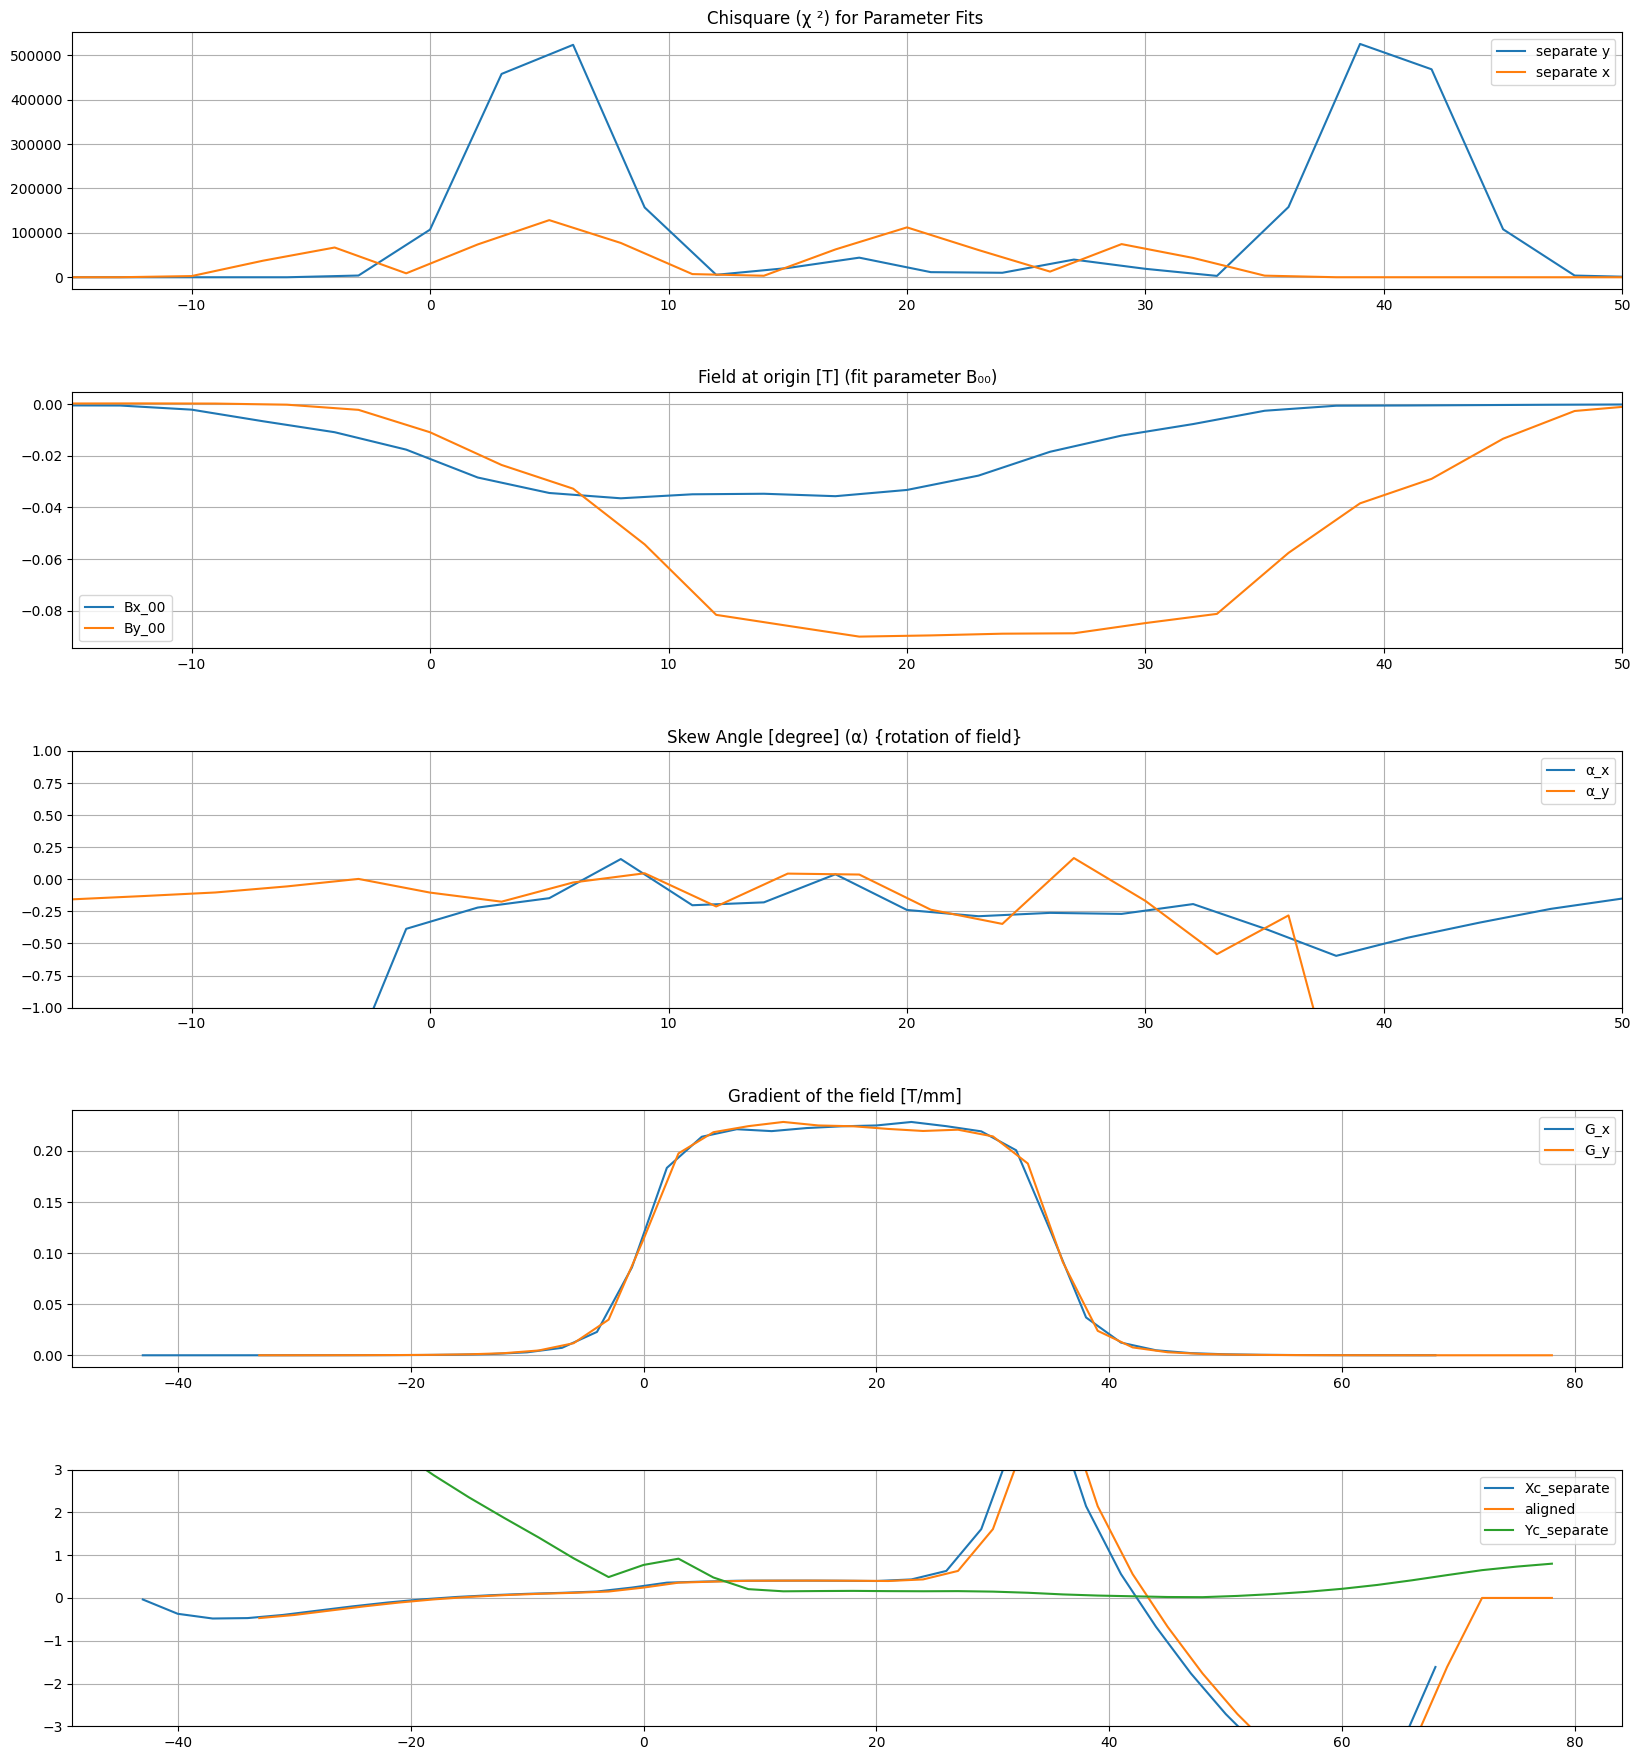

In [326]:

plt.figure(figsize=(20,22))
row = 5; col =1
plt.subplots_adjust(hspace =.4)
#plt.suptitle("{}__Common Fit".format(datafile), fontsize = 15)

plt.subplot(row,col,1)
#plt.plot(z_local_val,chisq_4param,'-',label='4param')
plt.plot(z_local2_val, chisq_y, '-', label='separate y')
plt.plot(z_local1_val, chisq_x, '-', label='separate x')
#plt.ylim(-.1,1e6)
plt.title('Chisquare (\u03C7 \u00b2) for Parameter Fits ')
plt.legend(loc='best')
plt.xlim(-15, 50)
plt.grid()

plt.subplot(row,col,2)
#plt.plot(z_local_val,Bx_00_4simult,'-',label='Bx_4param')
#plt.plot(z_local_val,By_00_4simult,'-',label='By_4param')
plt.plot(z_local1_val,Bx_00,'-',label='Bx_00')
plt.plot(z_local2_val,By_00,'-',label='By_00')
plt.xlim(-15, 50)
#plt.ylim(-0.05,+0.05)
plt.title('Field at origin [T] (fit parameter B\u2080\u2080)')
plt.legend(loc='best')
plt.grid()


plt.subplot(row,col,3)
#plt.plot(z_local_val,alpha,'-',label='\u03B1_4param')
plt.plot(z_local1_val,alpha_x,'-',label='\u03B1_x')
plt.plot(z_local2_val,alpha_y,'-',label='\u03B1_y')
plt.ylim(-1,1)
plt.xlim(-15, 50)
plt.title('Skew Angle [degree] (\u03B1) {rotation of field} ')
plt.legend(loc='best')
plt.grid()

plt.subplot(row,col,4)
#plt.plot(z_local_val,G,'-',label='G_4param')
plt.plot(z_local1_val,G_x,'-',label='G_x')
plt.plot(z_local2_val,G_y,'-',label='G_y')
#plt.ylim(-0.025,0.01)
#plt.xlim(-15, 50)
plt.title('Gradient of the field [T/mm] ')
plt.legend(loc='best')
plt.grid()

#------------------------------------------------------------------------
#treba alingnut magcentrex
magcentre_x_sep_aligned = []
i = 0
for i in range(len(z_local_val1)):
    if z_local_val1[i] > -25:
        magcentre_x_sep_aligned.append(magcentre_x_sep[i])
    else:
        i += 1

magcentre_x_sep_aligned.extend([0,0,0])

plt.subplot(row,col,5)
#plt.plot(z_local_val,magcentre_x,'-',label='Xc_4param')
#plt.plot(z_local_val,magcentre_y,'-',label='Yc_4param')
plt.plot(z_local1_val,magcentre_x_sep,'-',label='Xc_separate')
plt.plot(z_local2_val,magcentre_x_sep_aligned,'-', label='aligned')
plt.plot(z_local2_val,magcentre_y_sep,'-',label='Yc_separate')
plt.ylim(-3,3)
#plt.xlim(-15, 50)

plt.legend(loc='best')
plt.grid()    


In [327]:
generatedData = generateBLLR1(z_local2_val, alpha_y, G_y, magcentre_x_sep_aligned, magcentre_y_sep)

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


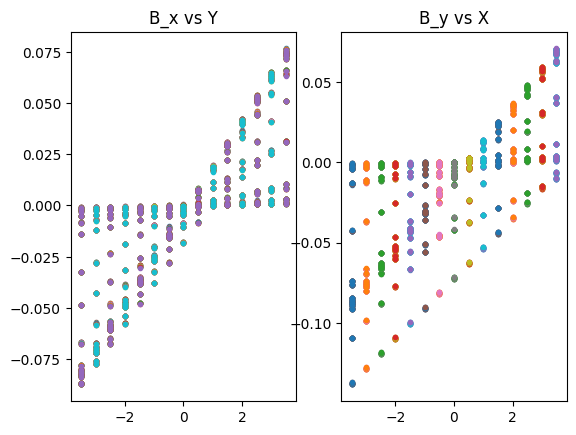

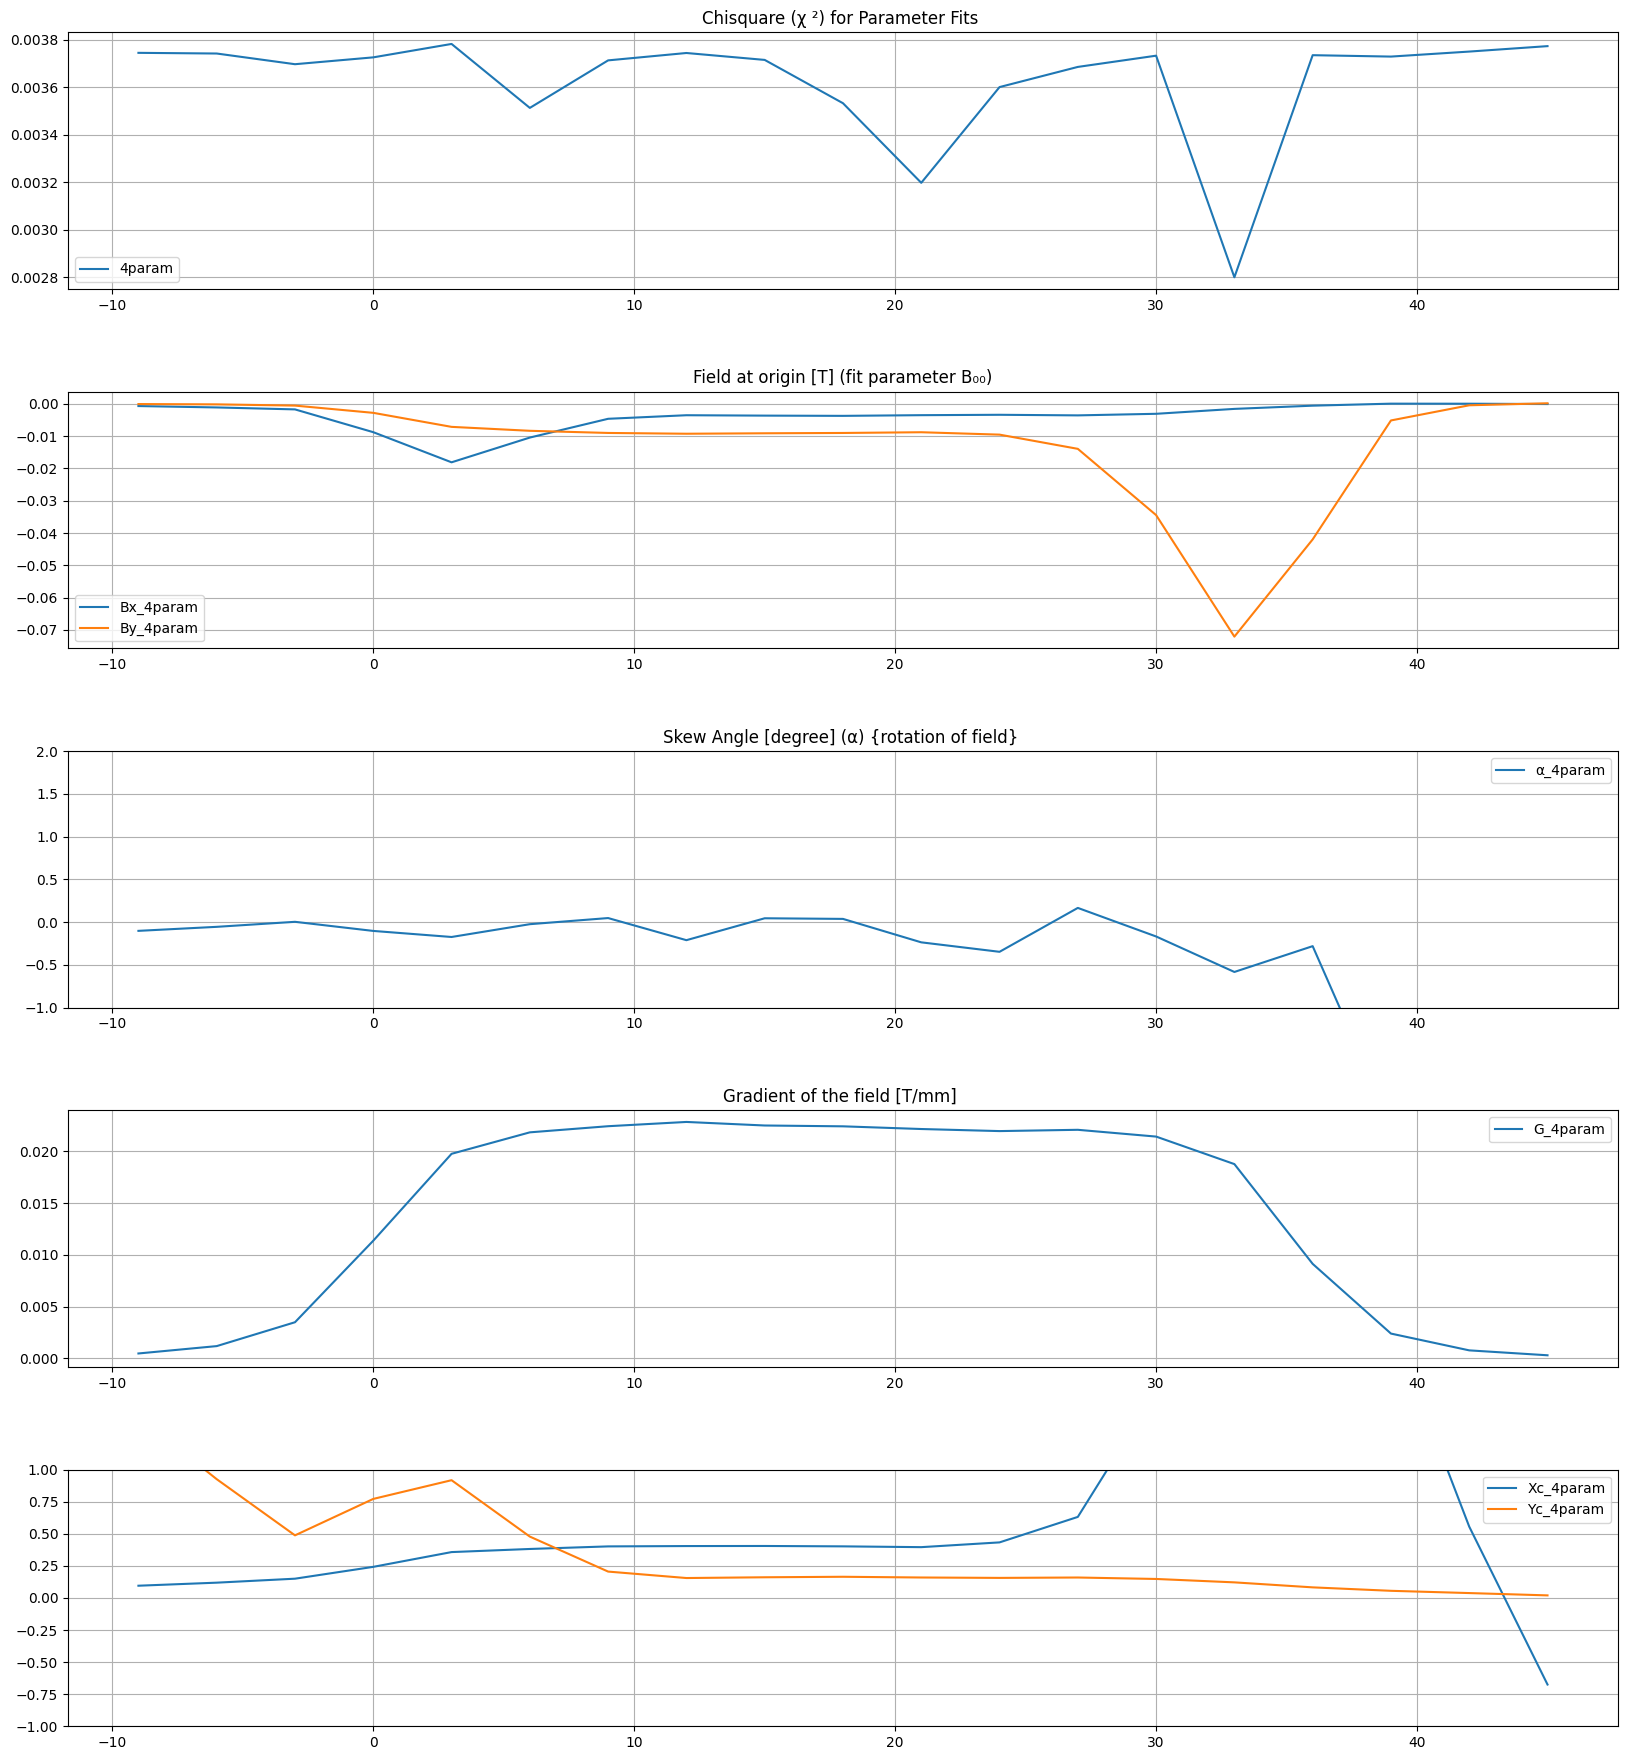

In [328]:
runOnceMore("PQMLLR1_generated.txt")